导入 Python 库&模块并配置运行信息

In [1]:
from easydict import EasyDict as edict  # 字典访问，用来存储超参数
import os  # os模块主要用于处理文件和目录
import numpy as np  # 科学计算库
import matplotlib.pyplot as plt  # 绘图库

import mindspore  # mindspore框架
import mindspore.dataset as ds  # 数据集处理模块
from mindspore.dataset.vision import c_transforms as vision  # 图像增强模块
from mindspore import context  # 环境设置模块
import mindspore.nn as nn  # 神经网络模块
from mindspore.train import Model  # 模型编译
from mindspore.nn.optim.momentum import Momentum  # 动量优化器
from mindspore.train.callback import (
    ModelCheckpoint,
    CheckpointConfig,
    LossMonitor,
)  # 模型保存设置
from mindspore import Tensor  # 张量
from mindspore.train.serialization import export  # 模型导出
from mindspore.train.loss_scale_manager import FixedLossScaleManager  # 损失值平滑处理
from mindspore.train.serialization import load_checkpoint, load_param_into_net  # 模型加载
import mindspore.ops as ops  # 常见算子操作

# 设置 MindSpore 的执行模式和设备
context.set_context(mode=context.GRAPH_MODE, device_target="CPU")

定义参数变量

In [2]:
cfg = edict(
    {
        "data_path": "flower_photos_train",  # 训练数据集路径
        "test_path": "flower_photos_test",  # 测试数据集路径
        "data_size": 3616,
        "HEIGHT": 224,  # 图像高度
        "WIDTH": 224,  # 图像宽度
        "_R_MEAN": 123.68,  # CIFAR10的均值
        "_G_MEAN": 116.78,
        "_B_MEAN": 103.94,
        "_R_STD": 1,  # 自定义的标准差
        "_G_STD": 1,
        "_B_STD": 1,
        "_RESIZE_SIDE_MIN": 256,  # 图像增强resiz值
        "_RESIZE_SIDE_MAX": 512,
        "batch_size": 32,  # 批次大小
        "num_class": 5,  # 分类数
        "epoch_size": 10,  # 训练轮数
        "loss_scale_num": 1024,
        "predix": "resnet-ai",  # 模型保存的名称
        "directory": "./model_resnet",  # 模型保存的路径
        "save_checkpoint_steps": 10,  # 每隔10步保存ckpt
    }
)

数据的读取和处理

训练数据集数量： 3616
测试数据集数量： 52
通道数/图像长/宽： (3, 224, 224)
一张图像的标签样式： 2


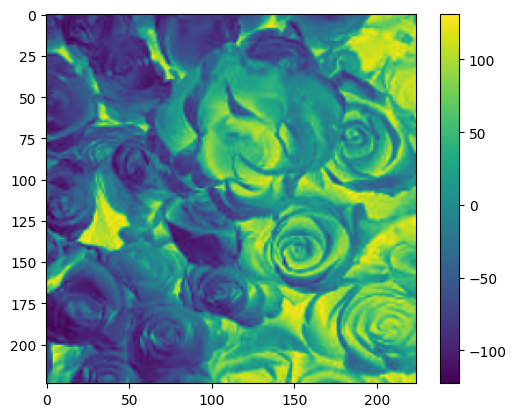

In [3]:
# 数据处理
def read_data(path, config, usage="train"):
    # 从目录中读取图像的源数据集。
    dataset = ds.ImageFolderDataset(
        path,
        class_indexing={
            "daisy": 0,
            "dandelion": 1,
            "roses": 2,
            "sunflowers": 3,
            "tulips": 4,
        },
    )
    # define map operations
    # 图像解码算子
    decode_op = vision.Decode()
    # 图像正则化算子
    normalize_op = vision.Normalize(
        mean=[cfg._R_MEAN, cfg._G_MEAN, cfg._B_MEAN],
        std=[cfg._R_STD, cfg._G_STD, cfg._B_STD],
    )
    # 图像调整大小算子
    resize_op = vision.Resize(cfg._RESIZE_SIDE_MIN)
    # 图像裁剪算子
    center_crop_op = vision.CenterCrop((cfg.HEIGHT, cfg.WIDTH))
    # 图像随机水平翻转算子
    horizontal_flip_op = vision.RandomHorizontalFlip()
    # 图像通道数转换算子
    changeswap_op = vision.HWC2CHW()
    # 图像随机裁剪解码调整大小算子
    random_crop_decode_resize_op = vision.RandomCropDecodeResize(
        (cfg.HEIGHT, cfg.WIDTH), (0.5, 1.0), (1.0, 1.0), max_attempts=100
    )

    # 只对训练集做的预处理操作
    if usage == "train":
        dataset = dataset.map(
            input_columns="image", operations=random_crop_decode_resize_op
        )
        dataset = dataset.map(input_columns="image", operations=horizontal_flip_op)
    # 只对测试集做的预处理操作
    else:
        dataset = dataset.map(input_columns="image", operations=decode_op)
        dataset = dataset.map(input_columns="image", operations=resize_op)
        dataset = dataset.map(input_columns="image", operations=center_crop_op)

    # 对全部数据做的预处理操作
    dataset = dataset.map(input_columns="image", operations=normalize_op)
    dataset = dataset.map(input_columns="image", operations=changeswap_op)

    # 对训练集做的批次处理
    if usage == "train":
        dataset = dataset.shuffle(buffer_size=1000)  # 10000 as in imageNet train script
        dataset = dataset.batch(cfg.batch_size, drop_remainder=True)
    # 对测试集做的批次处理
    else:
        dataset = dataset.batch(1, drop_remainder=True)

    # 数据增强
    dataset = dataset.repeat(1)
    dataset.map_model = 4
    return dataset


# 查看训练集和测试集的数量
de_train = read_data(cfg.data_path, cfg, usage="train")
de_test = read_data(cfg.test_path, cfg, usage="test")
print(
    "训练数据集数量：", de_train.get_dataset_size() * cfg.batch_size
)  # get_dataset_size()返回的是batch的数量
print("测试数据集数量：", de_test.get_dataset_size())

# 查看训练集的样图
data_next = de_train.create_dict_iterator(output_numpy=True).__next__()
print("通道数/图像长/宽：", data_next["image"][0, ...].shape)
print("一张图像的标签样式：", data_next["label"][0])  # 一共五类，用0-4表示

plt.figure()
plt.imshow(data_next["image"][0, 0, ...])
plt.colorbar()
plt.grid(False)
plt.show()

模型构建训练

In [4]:
# 定义权重初始化函数
def _weight_variable(shape, factor=0.01):
    init_value = np.random.randn(*shape).astype(np.float32) * factor
    return Tensor(init_value)


# 定义 3x3 卷积层
def _conv3x3(in_channel, out_channel, stride=1):
    weight_shape = (out_channel, in_channel, 3, 3)
    weight = _weight_variable(weight_shape)
    return nn.Conv2d(
        in_channel,
        out_channel,
        kernel_size=3,
        stride=stride,
        padding=0,
        pad_mode="same",
        weight_init=weight,
    )


# 定义 1x1 卷积层
def _conv1x1(in_channel, out_channel, stride=1):
    weight_shape = (out_channel, in_channel, 1, 1)
    weight = _weight_variable(weight_shape)
    return nn.Conv2d(
        in_channel,
        out_channel,
        kernel_size=1,
        stride=stride,
        padding=0,
        pad_mode="same",
        weight_init=weight,
    )


# 定义 7x7 卷积层
def _conv7x7(in_channel, out_channel, stride=1):
    weight_shape = (out_channel, in_channel, 7, 7)
    weight = _weight_variable(weight_shape)
    return nn.Conv2d(
        in_channel,
        out_channel,
        kernel_size=7,
        stride=stride,
        padding=0,
        pad_mode="same",
        weight_init=weight,
    )


# 定义 Batch Norm 层函数
def _bn(channel):
    return nn.BatchNorm2d(
        channel,
        eps=1e-4,
        momentum=0.9,
        gamma_init=1,
        beta_init=0,
        moving_mean_init=0,
        moving_var_init=1,
    )


# 定义最后一层的 Batch Norm 层函数
def _bn_last(channel):
    return nn.BatchNorm2d(
        channel,
        eps=1e-4,
        momentum=0.9,
        gamma_init=0,
        beta_init=0,
        moving_mean_init=0,
        moving_var_init=1,
    )


# 定义全连接层函数
def _fc(in_channel, out_channel):
    weight_shape = (out_channel, in_channel)
    weight = _weight_variable(weight_shape)
    return nn.Dense(
        in_channel, out_channel, has_bias=True, weight_init=weight, bias_init=0
    )


# 构建残差模块
class ResidualBlock(nn.Cell):
    def __init__(self, in_channel, out_channel, stride=1):
        super(ResidualBlock, self).__init__()
        self.expansion = 4
        # 前两层的卷积核个数等于输出通道的四分之一
        channel = out_channel // self.expansion

        # 第一层卷积
        self.conv1 = _conv1x1(in_channel, channel, stride=1)
        self.bn1 = _bn(channel)
        # 第二层卷积
        self.conv2 = _conv3x3(channel, channel, stride=stride)
        self.bn2 = _bn(channel)

        # 第三层卷积
        self.conv3 = _conv1x1(channel, out_channel, stride=1)
        self.bn3 = _bn_last(out_channel)

        # Relu 激活层
        self.relu = nn.ReLU()

        self.down_sample = False

        # 当步长不为1、或输出通道不等于输入通道时，进行图像下采样，用来调整通道数
        if stride != 1 or in_channel != out_channel:
            self.down_sample = True
        self.downsample_layer = None
        # 用 1x1 卷积调整通道数
        if self.down_sample:
            self.downsample_layer = nn.SequentialCell(
                [_conv1x1(in_channel, out_channel, stride), _bn(out_channel)]
            )

        # 加法算子
        self.add = ops.Add()

    # 构建残差块
    def construct(self, x):
        # 输入
        identity = x

        # 第一层卷积 1X1
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        # 第二层卷积 3X3
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        # 第三层卷积 1X1
        out = self.conv3(x)
        out = self.bn3(out)

        # 改变网络的维度
        if self.down_sample:
            identity = self.downsample_layer(identity)

        # 加上残差
        out = self.add(out, identity)
        # Relu 激活
        out = self.relu(out)

        return out


# 构建残差网络
class ResNet(nn.Cell):
    # 输入参数为：残差块，残差块重复数，输入通道，输出通道，步长，图像类别数
    def __init__(
        self, block, layer_nums, in_channels, out_channels, strides, num_classes
    ):
        super(ResNet, self).__init__()
        if not len(layer_nums) == len(out_channels) == len(strides) == 4:
            raise ValueError("the length of layer_num, out_channel, stride must be 4!")

        # 第一层卷积，卷积核 7X7，输入通道3，输出通道64，步长2
        self.conv1 = _conv7x7(3, 64, stride=2)
        self.bn1 = _bn(64)
        self.relu = nn.ReLU()

        # 最大池化层，核大小 3X3，步长 2
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, pad_mode="same")

        # conv2_x 残差块
        self.layer1 = self._make_layer(
            block,
            layer_nums[0],
            in_channel=in_channels[0],
            out_channel=out_channels[0],
            stride=strides[0],
        )

        # conv3_x 残差块
        self.layer2 = self._make_layer(
            block,
            layer_nums[1],
            in_channel=in_channels[1],
            out_channel=out_channels[1],
            stride=strides[1],
        )

        # conv4_x 残差块
        self.layer3 = self._make_layer(
            block,
            layer_nums[2],
            in_channel=in_channels[2],
            out_channel=out_channels[2],
            stride=strides[2],
        )

        # conv5_x 残差块
        self.layer4 = self._make_layer(
            block,
            layer_nums[3],
            in_channel=in_channels[3],
            out_channel=out_channels[3],
            stride=strides[3],
        )

        # 均值算子
        self.mean = ops.ReduceMean(keep_dims=True)
        # Flatten 层
        self.flatten = nn.Flatten()
        # 输出层
        self.end_point = _fc(out_channels[3], num_classes)

    # 输出参数为：残差块，残差块重复数，输入通道，输出通道，步长
    def _make_layer(self, block, layer_num, in_channel, out_channel, stride):
        layers = []
        # 第一个残差块可能改变维度，所以单独构建
        resnet_block = block(in_channel, out_channel, stride=stride)
        layers.append(resnet_block)

        for _ in range(1, layer_num):
            # 其他残差块维持不变
            resnet_block = block(out_channel, out_channel, stride=1)
            layers.append(resnet_block)

        return nn.SequentialCell(layers)

    # 构建 ResNet 网络
    def construct(self, x):
        # 第一层卷积
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        c1 = self.maxpool(x)

        c2 = self.layer1(c1)  # conv2_x 残差块
        c3 = self.layer2(c2)  # conv3_x 残差块
        c4 = self.layer3(c3)  # conv4_x 残差块
        c5 = self.layer4(c4)  # conv5_x 残差块

        out = self.mean(c5, (2, 3))  # 平均池化层
        out = self.flatten(out)  # Flatten 层
        out = self.end_point(out)  # 输出层

        return out


# 构建 ResNet50 网络
def resnet50(class_num=5):
    return ResNet(
        ResidualBlock,  # 残差块
        [3, 4, 6, 3],  # 残差块重复数
        [64, 256, 512, 1024],  # 输入通道
        [256, 512, 1024, 2048],  # 输出通道
        [1, 2, 2, 2],  # 步长
        class_num,  # 图像类别数
    )

开始训练

In [7]:
# 构建 ResNet50 网络，输出类别数为5，对应5种花的类别
net = resnet50(class_num=cfg.num_class)

# 读取预训练模型参数
param_dict = load_checkpoint(
    "model_resnet/resnet50_ascend_v170_imagenet2012_official_cv_top1acc76.97_top5acc93.44.ckpt"
)

# 展示读取的模型参数
print(param_dict)

# 通过 mindspore.Parameter() 修改 end_point.weight 和 end_point.bias 对应的 shape
param_dict["end_point.weight"] = mindspore.Parameter(
    Tensor(param_dict["end_point.weight"][:5, :], mindspore.float32), name="variable"
)
param_dict["end_point.bias"] = mindspore.Parameter(
    Tensor(param_dict["end_point.bias"][:5], mindspore.float32), name="variable"
)

# 设置 Softmax 交叉熵损失函数
loss = nn.SoftmaxCrossEntropyWithLogits(sparse=True, reduction="mean")

# 设置学习率
train_step_size = de_train.get_dataset_size()  # 训练集大小
lr = nn.cosine_decay_lr(
    min_lr=0.0001,
    max_lr=0.001,
    total_step=train_step_size * cfg.epoch_size,
    step_per_epoch=train_step_size,
    decay_epoch=cfg.epoch_size,
)

# 设置动量优化器
opt = Momentum(
    net.trainable_params(),
    lr,
    momentum=0.9,
    weight_decay=1e-4,
    loss_scale=cfg.loss_scale_num,
)

# 损失值平滑，解决训练过程中梯度过小的问题
loss_scale = FixedLossScaleManager(cfg.loss_scale_num, False)

# 模型编译，输入网络结构，损失函数，优化器，损失值平滑，以及模型评估标准
model = Model(
    net, loss_fn=loss, optimizer=opt, loss_scale_manager=loss_scale, metrics={"acc"}
)

# 损失值监控
loss_cb = LossMonitor(per_print_times=train_step_size)

# 模型保存参数，设置每隔多少步保存一次模型，最多保存几个模型
ckpt_config = CheckpointConfig(
    save_checkpoint_steps=cfg.save_checkpoint_steps, keep_checkpoint_max=1
)

# 模型保存，设置模型保存的名称，路径，以及保存参数
ckpoint_cb = ModelCheckpoint(
    prefix=cfg.ckpt_prefix, directory=cfg.directory, config=ckpt_config
)

print("============== Starting Training ==============")
# 训练模型，设置训练次数，训练集，回调函数，是否采用数据下沉模式（只能应用于 Ascend 和 GPU）
model.train(
    cfg.epoch_size, de_train, callbacks=[loss_cb, ckpoint_cb], dataset_sink_mode=True
)
# 训练时长 15-20 分钟

# 使用测试集进行模型评估，输出测试集的准确率
metric = model.eval(de_test)
print(metric)

{'conv1.weight': Parameter (name=conv1.weight, shape=(64, 3, 7, 7), dtype=Float32, requires_grad=True), 'bn1.gamma': Parameter (name=bn1.gamma, shape=(64,), dtype=Float32, requires_grad=True), 'bn1.beta': Parameter (name=bn1.beta, shape=(64,), dtype=Float32, requires_grad=True), 'layer1.0.conv1.weight': Parameter (name=layer1.0.conv1.weight, shape=(64, 64, 1, 1), dtype=Float32, requires_grad=True), 'layer1.0.bn1.gamma': Parameter (name=layer1.0.bn1.gamma, shape=(64,), dtype=Float32, requires_grad=True), 'layer1.0.bn1.beta': Parameter (name=layer1.0.bn1.beta, shape=(64,), dtype=Float32, requires_grad=True), 'layer1.0.conv2.weight': Parameter (name=layer1.0.conv2.weight, shape=(64, 64, 3, 3), dtype=Float32, requires_grad=True), 'layer1.0.bn2.gamma': Parameter (name=layer1.0.bn2.gamma, shape=(64,), dtype=Float32, requires_grad=True), 'layer1.0.bn2.beta': Parameter (name=layer1.0.bn2.beta, shape=(64,), dtype=Float32, requires_grad=True), 'layer1.0.conv3.weight': Parameter (name=layer1.0.co

AttributeError: 'EasyDict' object has no attribute 'ckpt_prefix'

模型预测

In [ ]:
# 模型预测，从测试集中取10个样本进行测试，输出预测结果和真实结果
class_names = {0: "daisy", 1: "dandelion", 2: "roses", 3: "sunflowers", 4: "tulips"}
for i in range(10):
    test_ = de_test.create_dict_iterator().__next__()
    test = Tensor(test_["image"], mindspore.float32)
    # 模型预测
    predictions = model.predict(test)
    predictions = predictions.asnumpy()
    true_label = test_["label"].asnumpy()
    # 显示预测结果
    p_np = predictions[0, :]
    pred_label = np.argmax(p_np)
    print(
        "第"
        + str(i)
        + "个样本的预测结果为："
        + class_names[pred_label]
        + "，真实结果为："
        + class_names[true_label]
    )